In [4]:
!nvidia-smi

Sat Aug 16 00:42:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Computing the PCA of a Foreground Object
We show in our paper many figures with object parts colored like rainbows. These visualizations are obtained by computing a PCA of patch features on the foreground object. This is what we will compute in this tutorial! Let's start by loading some pre-requisites.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [12]:
!git clone https://github.com/facebookresearch/dinov3.git


Cloning into 'dinov3'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 232 (delta 35), reused 217 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (232/232), 9.77 MiB | 34.25 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/dinov3


In [13]:
%cd ..

/content


In [14]:
import pickle
import os
import urllib

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from scipy import signal

DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to facebookresearch/dinov3


### Model Loading
We load the DINOv3 ViT-L model. Feel free to try other DINOv3 models as well!

In [7]:
!wget "https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoicjhyM20xMGpnbmh6czMxZHNnMzc0cTVhIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU0Nzc4NzF9fX1dfQ__&Signature=nuKR2WV9JWF%7Eyq-xCA6Lz1ZVL0RK8xEThjZYCcs6MqwW-aUDF0T5uECecazfoGcK-3dC5Ptn4XHsvIpmppO1CJ7UmKKpxD8zEmcDxBhSKAA1VHMlIdxzOxNPwf8x2D-x1aPJKjNnd9YNwKFGgYFmmW05ify6EhCf4NjYBHkBmbFzH8PAP8RNwtWO66JS0wJQLhBe9wEcLXRvinePInG%7EhTwxe-CbHpZtpjPBAe7VkNlJHUsO2Ie3AUeQ4ChLk9kp%7E-XI9-ax0eHEWEKV49fPeo94JHw6fDOLlb96D7uiahCSe0uzh2cigQU4NNAXc5FPhBiOHKVgNdL-gBNFq-i59Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=661517346961544"


The destination name is too long (690), reducing to 236
--2025-08-16 00:47:41--  https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoicjhyM20xMGpnbmh6czMxZHNnMzc0cTVhIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU0Nzc4NzF9fX1dfQ__&Signature=nuKR2WV9JWF%7Eyq-xCA6Lz1ZVL0RK8xEThjZYCcs6MqwW-aUDF0T5uECecazfoGcK-3dC5Ptn4XHsvIpmppO1CJ7UmKKpxD8zEmcDxBhSKAA1VHMlIdxzOxNPwf8x2D-x1aPJKjNnd9YNwKFGgYFmmW05ify6EhCf4NjYBHkBmbFzH8PAP8RNwtWO66JS0wJQLhBe9wEcLXRvinePInG%7EhTwxe-CbHpZtpjPBAe7VkNlJHUsO2Ie3AUeQ4ChLk9kp%7E-XI9-ax0eHEWEKV49fPeo94JHw6fDOLlb96D7uiahCSe0uzh2cigQU4NNAXc5FPhBiOHKVgNdL-gBNFq-i59Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=661517346961544
Resolving dinov3.llamameta.net (dinov3.llamameta.net)... 3.165.160.25, 3.165.160.74, 3.165.160.69, ...
Connecting to dinov3.llamameta.net (dinov3.llamameta.net)|3.165.160.25|:443.

In [9]:
model =torch.load("/content/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoicjhyM20xMGpnbmh6czMxZHNnMzc0cTVhIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpF")

In [11]:
#LOAD /content/dinov3_vits16_pretrain_lvd1689m-08c60483.pth
model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model="dinov3_vits16",
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
)
model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main
Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vits16_pretrain_lvd1689m-08c60483.pth


HTTPError: HTTP Error 403: Forbidden

In [15]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITL

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
)
model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main
Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


HTTPError: HTTP Error 403: Forbidden

In [19]:
import torch
import os

MODEL_NAME = "dinov3_vits16"  # ViT-L/16

# 1) Build the architecture only (skip the URL download)
model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
    pretrained=False,          # <-- prevents the download that 403s
    trust_repo=True,           # quiets hub warnings on local repos
)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


In [20]:
ckpt_path = "/content/dinov3_vits16_pretrain_lvd1689m-08c60483.pth"  # adjust if different
checkpoint = torch.load(ckpt_path, map_location="cpu")
state = checkpoint.get("model", checkpoint)

# If keys are "module.*" (DDP), strip the prefix
if any(k.startswith("module.") for k in state.keys()):
    state = {k.replace("module.", "", 1): v for k, v in state.items()}

msg = model.load_state_dict(state, strict=False)
print("Missing keys:", msg.missing_keys)
print("Unexpected keys:", msg.unexpected_keys)

model.cuda().eval()

Missing keys: []
Unexpected keys: []


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

### Loading the Foreground Classifier from the Other Tutorial
For this tutorial, we use the classifier trained in the `foreground_segmentation` notebook. If you haven't already, have a look! Once you have trained your foreground / background classifier on patch features, you should be able to load it here.

In [21]:
save_root = '.'
model_path = os.path.join(save_root, "fg_classifier.pkl")
with open(model_path, 'rb') as file:
    clf = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: './fg_classifier.pkl'

### Loading an Image and Applying the Right Transform
Let's load an image and process it in order to make it a multiple of the patch size.

In [37]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

image_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/pca/test_image.jpg"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))


# image = load_image_from_url(image_uri)
image = Image.open("/content/ima22288-fig-0001-m.jpg")
image_resized = resize_transform(image)
image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

### Model Forward
Given the input image, we compute local features:

In [38]:
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(image_resized_norm.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

In [39]:
h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]


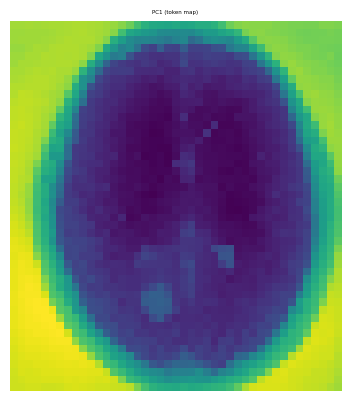

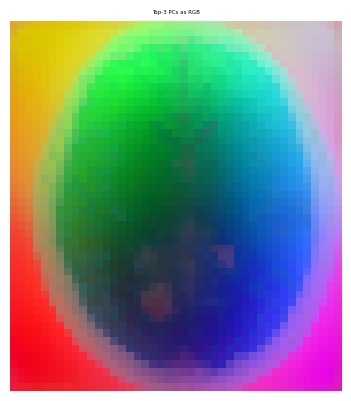

Explained variance ratios (PC1..PC3): [0.235543355345726, 0.1281302571296692, 0.10038603842258453]


In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# x: (N=H*W, D) from your code above
N, D = x.shape
H = h_patches                        # you said H = 48
W = N // H
assert H * W == N, f"Token grid mismatch: N={N}, H={H}, W={W}"

# 1) center the data (float32 for numerical stability)
X = x.float()
X = X - X.mean(0, keepdim=True)

# 2) PCA (top 3)
U, S, V = torch.pca_lowrank(X, q=3, center=False)   # X already centered
scores = X @ V[:, :3]                               # (N, 3)

# 3) PC1 heatmap (H, W)
pc1 = scores[:, 0].reshape(H, W).cpu().numpy()
pc1 = (pc1 - pc1.min()) / (pc1.max() - pc1.min() + 1e-8)

plt.figure()
plt.title("PC1 (token map)")
plt.imshow(pc1)
plt.axis("off")
plt.show()

# 4) Top-3 PCs as RGB
pc_rgb = scores.reshape(H, W, 3).cpu().numpy()
mn = pc_rgb.reshape(-1, 3).min(axis=0, keepdims=True)
mx = pc_rgb.reshape(-1, 3).max(axis=0, keepdims=True)
pc_rgb = (pc_rgb - mn) / (mx - mn + 1e-8)

plt.figure()
plt.title("Top-3 PCs as RGB")
plt.imshow(pc_rgb)
plt.axis("off")
plt.show()

# 5) (optional) scatter + explained variance
# plt.figure()
# plt.title("Tokens in PC1 vs PC2")
# plt.scatter(scores[:, 0].cpu().numpy(), scores[:, 1].cpu().numpy(), s=8, alpha=0.6)
# plt.xlabel("PC1"); plt.ylabel("PC2")
# plt.show()

total_ss = (X ** 2).sum()
print("Explained variance ratios (PC1..PC3):",
      [float((S[i]**2)/total_ss) for i in range(min(3, S.numel()))])


### Computing Foreground Probability
Let's now pass all those features through our foreground classifier, extract probabilities, and reshape.

In [24]:
h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
    "axes.titlesize": 4,
})

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title(f"Image, Size {image.size}")
plt.subplot(1, 2, 2)
plt.imshow(fg_score_mf)
plt.title(f"Foreground Score, Size {tuple(fg_score_mf.shape)}")
plt.colorbar()
plt.axis('off')
plt.show()

NameError: name 'clf' is not defined

### Extracting Foreground Patches
We find the patches with positive classifier output, in order to fit the PCA only on the foreground.

In [25]:
foreground_selection = fg_score_mf.view(-1) > 0.5
fg_patches = x[foreground_selection]

NameError: name 'fg_score_mf' is not defined

### Fitting the PCA
We use 3 components, and use whitening.

In [26]:
pca = PCA(n_components=3, whiten=True)
pca.fit(fg_patches)

NameError: name 'fg_patches' is not defined

### Applying the PCA, and Masking Background
Finally, we project the features using the PCA, and apply a mask to set the background to black.

In [28]:
# apply the PCA, and then reshape
projected_image = torch.from_numpy(pca.transform(x.numpy())).view(h_patches, w_patches, 3)

# multiply by 2.0 and pass through a sigmoid to get vibrant colors
projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0)).permute(2, 0, 1)

# mask the background using the fg_score_mf
projected_image *= (fg_score_mf.unsqueeze(0) > 0.5)

# enjoy
plt.figure(dpi=300)
plt.imshow(projected_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

AttributeError: 'PCA' object has no attribute 'components_'